# ChessGPT

In [1]:
import chess
from chess import Move
import random
import numpy as np
import openai
import json

Explanation AI

In [2]:
# config.json
# {
#     "OPENAI_API_KEY": your api key
# }

f = open("./config.json")
data = json.load(f)
f.close()

In [3]:
openai.api_key = data['OPENAI_API_KEY']
model_engine = "gpt-3.5-turbo" 

In [4]:
intro_message = "You are a chess tutor for a beginner player playing as white."

In [5]:
goal_message = "Your goal is to offer give advice to a beginner player during a game. I will give you a move sequence, and you will comment on the state of the game and the latest move in the sequence, and offer possible next moves for white, stating them in UCI representation (e.g. a1a3). Please answer as if you are speaking directly to the player."

In [6]:
response = openai.ChatCompletion.create(
    model='gpt-3.5-turbo',
    messages=[
        {"role": "system", "content": intro_message},
        {"role": "user", "content": "Hello, ChatGPT!"},
    ])

message = response.choices[0]['message']
print("{}: {}".format(message['role'], message['content']))

assistant: Hello Beginner Chess Player! How can I assist you today with our chess lessons? Let's start with the basics. Have you learned about the movements of each piece on the chessboard?


In [7]:
response = openai.ChatCompletion.create(
    model='gpt-3.5-turbo',
    messages=[
        {"role": "system", "content": goal_message},
        {"role": "user", "content": "'1. g1f3 g8f6 2. b1c3 b8c6 3. e2e4 e7e5 4. f3e5 f6e4 5. c3e4 f8b4 6. f1c4 c6e5 7. e1g1 e8g8 8. c4f7 f8f7 9. d2d4 d7d5 10. c1f4 c8e6'"},
    ])

message = response.choices[0]['message']
print("{}: {}".format(message['role'], message['content']))

assistant: Hello! Let's take a look at the current position. You have a strong pawn center, but you have given up your knight and bishop for black's knight and dark-squared bishop. Black also has a pin on your f7 pawn with their bishop.

In response to black's last move, 10...c8e6, one possible move for white is 11. f4xe6. This captures the pawn on e6 with your bishop and breaks the pin on your f7 pawn. Black will likely recapture with their d7 pawn, but then you can bring your queen into the game with 12. Qd1e2, attacking the d7 pawn and preparing to castle on the kingside.

Another option is to continue developing your pieces with 11. Ng1f3, putting pressure on the e4 pawn and preparing to castle on the kingside. Black may then continue with 11...Bc8g4, attacking your knight, but you could respond with 12. h2h3, forcing the bishop to retreat and maintaining your knight's pressure on e4.

Overall, your position is solid, and you have a couple of strong options to choose from. Just rem

Chess AI

In [8]:
# EVALUATION
# https://www.chessprogramming.org/Simplified_Evaluation_Function

points = {
    'P': 100,   # Pawn
    'N': 320,   # Knight
    'B': 330,   # Bishop
    'R': 500,   # Rook
    'Q': 900,   # Queen
    'K': 20000  # King
}

# Piece square tables
# top left: a1, top right: a8, bottom left: h1, bottom right: h8
# modified to match square coordinates in chess library
pst = {
    # Pawn
    'P': np.array([[  0,   5,   5,   0,   5,  10,  50,   0],
                   [  0,  10,  -5,   0,   5,  10,  50,   0],
                   [  0,  10, -10,   0,  10,  20,  50,   0],
                   [  0, -20,   0,  20,  25,  30,  50,   0],
                   [  0, -20,   0,  20,  25,  30,  50,   0],
                   [  0,  10, -10,   0,  10,  20,  50,   0],
                   [  0,  10,  -5,   0,   5,  10,  50,   0],
                   [  0,   5,   5,   0,   5,  10,  50,   0]]),
    # Knight
    'N': np.array([[-50, -40, -30, -30, -30, -30, -40, -50],
                   [-40, -20,   5,   0,   5,   0, -20, -40],
                   [-30,   0,  10,  15,  15,  10,   0, -30],
                   [-30,   5,  15,  20,  20,  15,   0, -30],
                   [-30,   5,  15,  20,  20,  15,   0, -30],
                   [-30,   0,  10,  15,  15,  10,   0, -30],
                   [-40, -20,   5,   0,   5,   0, -20, -40],
                   [-50, -40, -30, -30, -30, -30, -40, -50]]),
    # Bishop
    'B': np.array([[-20, -10, -10, -10, -10, -10, -10, -20],
                   [-10,   5,  10,   0,   5,   0,   0, -10],
                   [-10,   0,  10,  10,   5,   5,   0, -10],
                   [-10,   0,  10,  10,  10,  10,   0, -10],
                   [-10,   0,  10,  10,  10,  10,   0, -10],
                   [-10,   0,  10,  10,   5,   5,   0, -10],
                   [-10,   5,  10,   0,   5,   0,   0, -10],
                   [-20, -10, -10, -10, -10, -10, -10, -20]]),
    # Rook
    'R': np.array([[ 0, -5, -5, -5, -5, -5,  5,  0],
                   [ 0,  0,  0,  0,  0,  0, 10,  0],
                   [ 0,  0,  0,  0,  0,  0, 10,  0],
                   [ 5,  0,  0,  0,  0,  0, 10,  0],
                   [ 5,  0,  0,  0,  0,  0, 10,  0],
                   [ 0,  0,  0,  0,  0,  0, 10,  0],
                   [ 0,  0,  0,  0,  0,  0, 10,  0],
                   [ 0, -5, -5, -5, -5, -5,  5,  0]]),
    # Queen
    'Q': np.array([[-20, -10, -10,   0,  -5, -10, -10, -20],
                   [-10,   0,   5,   0,   0,   0,   0, -10],
                   [-10,   5,   5,   5,   5,   5,   0, -10],
                   [ -5,   0,   5,   5,   5,   5,   0,  -5],
                   [ -5,   0,   5,   5,   5,   5,   0,  -5],
                   [-10,   0,   5,   5,   5,   5,   0, -10],
                   [-10,   0,   0,   0,   0,   0,   0, -10],
                   [-20, -10, -10,  -5,  -5, -10, -10, -20]]),
    # King - middle of game
    'K_middle': np.array([[ 20,  20, -10, -20, -30, -30, -30, -30],
                          [ 30,  20, -20, -30, -40, -40, -40, -40],
                          [ 10,   0, -20, -30, -40, -40, -40, -40],
                          [  0,   0, -20, -40, -50, -50, -50, -50],
                          [  0,   0, -20, -40, -50, -50, -50, -50],
                          [ 10,   0, -20, -30, -40, -40, -40, -40],
                          [ 30,  20, -20, -30, -40, -40, -40, -40],
                          [ 20,  20, -10, -20, -30, -30, -30, -30]]),
    # King - endgame
    'K_end': np.array([[-50, -30, -30, -30, -30, -30, -30, -50],
                       [-30, -30, -10, -10, -10, -10, -20, -40],
                       [-30,   0,  20,  30,  30,  20, -10, -30],
                       [-30,   0,  30,  40,  40,  30,   0, -20],
                       [-30,   0,  30,  40,  40,  30,   0, -20],
                       [-30,   0,  20,  30,  30,  20, -10, -30],
                       [-30, -30, -10, -10, -10, -10, -20, -40],
                       [-50, -30, -30, -30, -30, -30, -30, -50]])
 }

# "Additionally we should define where the ending begins. For me it might be either if:
# Both sides have no queens or
# Every side which has a queen has additionally no other pieces or one minorpiece maximum."
# Use to pick which piece square table to use for king
def is_endgame(board):
    fen_str = board.board_fen()
    if fen_str.lower().count('q') == 0:
        # both sides have no queen
        return True
    else:
        # True if side doesn't have a queen
        white_check = not ('Q' in fen_str)
        black_check = not ('q' in fen_str)
        # check if every side that has a queen has additionally no other pieces or one minor piece maximum
        if not white_check and sum(int(c.isupper()) for c in fen_str) <= 3: # includes queen and king
            white_check = True
        if not black_check and sum(int(c.islower()) for c in fen_str) <= 3:
            black_check = True
        return white_check and black_check

def get_board_points(board):
    # Points for pieces on board + bonus points for piece positions (piece square tables)
    points_diff = 0
    for square_num, piece in board.piece_map().items():
        symbol = piece.symbol()
        if symbol.islower():
            square_num = chess.square_mirror(square_num)
            pts_sign = -1
        else:
            pts_sign = 1
        
        square_coords = (chess.square_file(square_num), chess.square_rank(square_num))

        if symbol.upper() == "K":
            if is_endgame(board):
                symbol += "_end"
            else:
                symbol += "_middle"
        
        points_diff += pts_sign * pst[symbol.capitalize()][square_coords]

    return points_diff

In [9]:
# SEARCH
# currently only returns one move with min/max score, can modify to return dictionaries with multiple moves if we want to randomize game a bit

def minimax(board, depth, maximizing_player, moves_list = ()):
    if depth == 0 or len(list(board.legal_moves)) == 0:
        return moves_list, get_board_points(board)
    
    if maximizing_player:
        value = float('-inf')
        final_moves_list = ()

        for move in list(board.legal_moves):
            board_copy = board.copy()
            board_copy.push(move)
            new_moves_list = moves_list + (move.uci(),)

            best_move, move_points = minimax(board_copy, depth - 1, not maximizing_player, new_moves_list)
            if move_points > value:
                final_moves_list = best_move
                value = move_points
            
        return final_moves_list, value
    
    else:
        value = float('inf')
        final_moves_list = ()

        for move in list(board.legal_moves):
            board_copy = board.copy()
            board_copy.push(move)
            new_moves_list = moves_list + (move.uci(),)

            best_move, move_points = minimax(board_copy, depth - 1, not maximizing_player, new_moves_list)
            if move_points < value:
                final_moves_list = best_move
                value = move_points
            
        return final_moves_list, value


def alpha_beta_fail_hard(board, depth, maximizing_player, alpha = float('-inf'), beta = float('inf'), moves_list = ()):
    if depth == 0 or len(list(board.legal_moves)) == 0:
        return moves_list, get_board_points(board)

    if maximizing_player:
        value = float('-inf')
        final_moves_list = ()

        for move in list(board.legal_moves):
            board_copy = board.copy()
            board_copy.push(move)
            new_moves_list = moves_list + (move.uci(),)
            
            best_move, move_points = alpha_beta_fail_hard(board_copy, depth - 1, not maximizing_player, alpha, beta, new_moves_list)
            if move_points > value:
                final_moves_list = best_move
                value = move_points
            
            if value > beta:
                break
            alpha = max(alpha, value)
        
        return final_moves_list, value
    
    else:
        value = float('inf')
        final_moves_list = ()

        for move in list(board.legal_moves):
            board_copy = board.copy()
            board_copy.push(move)
            new_moves_list = moves_list + (move.uci(),)
            
            best_move, move_points = alpha_beta_fail_hard(board_copy, depth - 1, not maximizing_player, alpha, beta, new_moves_list)
            if move_points < value:
                final_moves_list = best_move
                value = move_points
            
            if value < alpha:
                break
            beta = min(beta, value)
        
        return final_moves_list, value

def alpha_beta_fail_soft(board, depth, maximizing_player, alpha = float('-inf'), beta = float('inf'), moves_list = ()):
    if depth == 0 or len(list(board.legal_moves)) == 0:
        return moves_list, get_board_points(board)

    if maximizing_player:
        value = float('-inf')
        final_moves_list = ()

        for move in list(board.legal_moves):
            board_copy = board.copy()
            board_copy.push(move)
            new_moves_list = moves_list + (move.uci(),)
            
            best_move, move_points = alpha_beta_fail_soft(board_copy, depth - 1, not maximizing_player, alpha, beta, new_moves_list)
            if move_points > value:
                final_moves_list = best_move
                value = move_points
            
            alpha = max(alpha, value)
            if value >= beta:
                break
        
        return final_moves_list, value
    
    else:
        value = float('inf')
        final_moves_list = ()

        for move in list(board.legal_moves):
            board_copy = board.copy()
            board_copy.push(move)
            new_moves_list = moves_list + (move.uci(),)
            
            best_move, move_points = alpha_beta_fail_soft(board_copy, depth - 1, not maximizing_player, alpha, beta, new_moves_list)
            if move_points < value:
                final_moves_list = best_move
                value = move_points
            
            beta = min(beta, value)
            if value <= alpha:
                break
        
        return final_moves_list, value

In [10]:
# GAMEPLAY

class RandomPlayer():
    def __init__(self, color = True):
        self.color = color

    def get_move(self, board):
        return random.choice(list(board.legal_moves))

class AIPlayer():
    def __init__(self, color = True, algo = "minimax", depth = 1):
        self.color = color
        self.algo = algo
        self.depth = depth

    def get_move(self, board):
        if self.algo == "AB_hard":
            moves, _ = alpha_beta_fail_hard(board, self.depth, board.turn)
        elif self.algo == "AB_soft":
            moves, _ = alpha_beta_fail_soft(board, self.depth, board.turn)
        else:
            moves, _ = minimax(board, self.depth, board.turn)
        return Move.from_uci(moves[0])

# could also add human player for testing later
class HumanPlayer():
    def __init__(self, color = True):
        self.color = color

    def get_move(self, board):
        return None

def who(player):
    if player == chess.WHITE:
        return "WHITE"
    elif player == chess.BLACK:
        return "BLACK"
    return None

def play_game_max_moves(player1, player2, board = None, max_moves = 0, per_side = True):
    if board == None:
        board = chess.Board()
    game_moves = []
    if per_side:
        max_moves *= 2
    while max_moves > 0 and not board.is_game_over(claim_draw=True):
        if board.turn == player1.color:
            move = player1.get_move(board)
        else:
            move = player2.get_move(board)
        game_moves.append(move.uci())
        board.push(move)
        max_moves -= 1
    if not board.is_game_over(claim_draw=True):
        print("Game not over")
    else:
        outcome = board.outcome()
        if outcome == None:
            t = "DRAW"
            w = None
        else:
            t = str(outcome.termination).split('.')[1]
            w = who(outcome.winner)
        print(f"Outcome: {t}\nWinner: {w}\nNumber of moves: {len(game_moves)}")
    print("================================================================")
    print("Moves:\tWHITE\tBLACK\n        -------------")
    for i in range(int(np.ceil(len(game_moves) / 2))):
        next_moves = game_moves[(i*2):(i*2 + 2)]
        if len(next_moves) == 1:
            print(f"{i+1:>6}  {next_moves[0]}")
        else:
            print(f"{i+1:>6}  {next_moves[0]}\t{next_moves[1]}")
    return board

def play_game(player1, player2, board = None):
    if board == None:
        board = chess.Board()
    game_moves = []
    while not board.is_game_over(claim_draw=True):
        if board.turn == player1.color:
            move = player1.get_move(board)
        else:
            move = player2.get_move(board)
        game_moves.append(move.uci())
        board.push(move)
    outcome = board.outcome()
    if outcome == None:
        t = "DRAW"
        w = None
    else:
        t = str(outcome.termination).split('.')[1]
        w = who(outcome.winner)
    print(f"Outcome: {t}\nWinner: {w}\nNumber of moves: {len(game_moves)}")
    print("================================================================")
    print("Moves:\tWHITE\tBLACK\n        -------------")
    for i in range(int(np.ceil(len(game_moves) / 2))):
        next_moves = game_moves[(i*2):(i*2 + 2)]
        if len(next_moves) == 1:
            print(f"{i+1:>6}  {next_moves[0]}")
        else:
            print(f"{i+1:>6}  {next_moves[0]}\t{next_moves[1]}")

def play_random_game():
    r1 = RandomPlayer(color = True) # white
    r2 = RandomPlayer(color = False) # black
    play_game(r1, r2)

In [11]:
board = chess.Board()
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


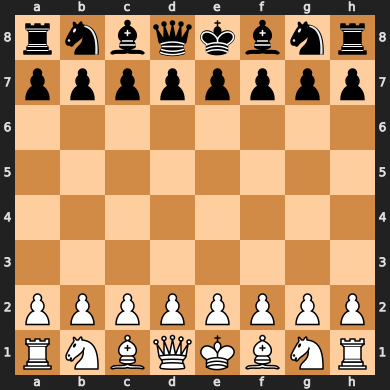

In [12]:
board

On starting board: avg time (sec) over 100 runs (depth 1-3) or 5 runs (depth 4)

* depth 1: Minimax: 0.0078, AB Fail Hard: 0.0080, AB Fail Soft: 0.0077
* depth 2: Minimax: 0.1551, AB Fail Hard: 0.0358, AB Fail Soft: 0.0281
* depth 3: Minimax: 3.4503, AB Fail Hard: 0.3359, AB Fail Soft: 0.2769
* depth 4: Minimax: 73.2331, AB Fail Hard: 1.4265, AB Fail Soft: 1.0175

In [13]:
board = play_game_max_moves(RandomPlayer(color = True), # white
                            RandomPlayer(color = False), # black
                            max_moves = 15)

Game not over
Moves:	WHITE	BLACK
        -------------
     1  g1f3	d7d6
     2  f3g1	g8h6
     3  d2d4	h6f5
     4  b2b4	h7h6
     5  e1d2	d8d7
     6  d2c3	d7c6
     7  c3b2	c6f3
     8  c2c4	f3f4
     9  b1a3	f5g3
    10  a3b1	f4d4
    11  b2a3	g7g5
    12  e2e4	a7a5
    13  f1e2	d4e5
    14  c1f4	c8e6
    15  f2g3	b8d7


In [14]:
minimax(board, 1, board.turn)

(('g1f3',), -25)

In [15]:
minimax(board, 2, board.turn)

(('g1f3', 'e5e4'), -45)

In [16]:
minimax(board, 3, board.turn)

(('b1c3', 'e5c3', 'd1b3'), -25)

In [17]:
alpha_beta_fail_hard(board, 1, board.turn)

(('g1f3',), -25)

In [18]:
alpha_beta_fail_hard(board, 2, board.turn)

(('g1f3', 'e5e4'), -45)

In [19]:
alpha_beta_fail_hard(board, 3, board.turn)

(('b1c3', 'e5c3', 'd1b3'), -25)

In [20]:
alpha_beta_fail_hard(board, 4, board.turn)

(('b1c3', 'e5c3', 'd1b3', 'g5f4'), -45)

In [21]:
alpha_beta_fail_soft(board, 1, board.turn)

(('g1f3',), -25)

In [22]:
alpha_beta_fail_soft(board, 2, board.turn)

(('g1f3', 'e5e4'), -45)

In [23]:
alpha_beta_fail_soft(board, 3, board.turn)

KeyboardInterrupt: 

In [ ]:
alpha_beta_fail_soft(board, 4, board.turn)

In [ ]:
play_game(AIPlayer(True, algo="AB_soft", depth=3),
          AIPlayer(False, algo="AB_soft",depth=3))

In [ ]:
play_game(RandomPlayer(True),
          AIPlayer(False, algo="AB_soft",depth=3))

In [ ]:
play_random_game()

Random notes:

Pseudo legal moves can leave king in check, legal moves don't

In [ ]:
print("hi")